# Praca domowa 5 - random serach dla modelu random forest - podzbiór
Odtworzenie modeli z artykułu [Predictive modeling in urgent care: a comparative study of machine learning approaches](https://academic.oup.com/jamiaopen/article/1/1/87/5032901) .

Link do repozytorium tego artykułu: [https://github.com/illidanlab/urgent-care-comparative](https://github.com/illidanlab/urgent-care-comparative) .

In [8]:
import pickle
import numpy as np
import pandas as pd

## Dane po preprocessingu

- Zmienna `X` została stworzona na podstawie cech, będących szeregami czasowymi. Każda taka cecha przerobiona została na min, średnią, max oraz odchylenie standardowe.

In [9]:
X = np.load("X48.npy")
X

array([[4.22535211e-02, 0.00000000e+00, 5.43478261e-02, ...,
        4.03017024e-01, 1.33952979e-01, 4.75067826e-01],
       [2.58215962e-01, 1.18421053e-01, 3.26086957e-01, ...,
        4.10958588e-14, 0.00000000e+00, 0.00000000e+00],
       [2.11267606e-01, 4.05553814e-01, 8.69565217e-02, ...,
        2.52207581e-01, 1.88907108e-01, 2.31845699e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.10958588e-14, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.10526316e-01, 0.00000000e+00, ...,
        2.64952543e-01, 2.88610525e-01, 4.89848547e-02],
       [3.20522201e-01, 1.57894737e-01, 0.00000000e+00, ...,
        4.83805376e-02, 3.83338758e-02, 1.06946021e-01]])

In [10]:
# this function was simplified a bit
def get_task():
    # returns target for in-hospital mortality
    with open("y", "rb") as f:
        labels = pickle.load(f)
    
    temp = [yy[0] for yy in labels]
    
    return np.array(temp)

- Zmienna `y` jest wektorem 0-1. 0 oznacza, iż dany pacjent przeżył, 1, że nie.

In [11]:
y = get_task()
y

array([0, 0, 0, ..., 0, 0, 0])

## Trenowanie hiperparamentrów

### Wzięcie podzbioru 1000 obserwacji

In [12]:
import random
random.seed(123)

X_pd = pd.DataFrame(X)
i = random.sample( range(27616), 1000)
X_sample = X_pd.iloc[i,]
y_sample = y[i]

### Random forest

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [13]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

In [14]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [26]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1, scoring = 'roc_auc')
rf_random.fit(X_sample, y_sample)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 66.6min finished


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [30]:
df = pd.DataFrame(rf_random.cv_results_)
df = df[["rank_test_score","mean_test_score","std_test_score",
    "param_n_estimators","param_min_samples_split","param_min_samples_leaf","param_max_features","param_max_depth","param_bootstrap"]]
df.sort_values( "rank_test_score",  inplace=True)

,rank_test_score,mean_test_score,std_test_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap
61,1,0.805663,0.031794,400,2,4,sqrt,10,True
87,2,0.805084,0.036111,1600,2,4,sqrt,80,True
41,3,0.803538,0.037607,600,10,2,sqrt,60,True
33,4,0.803202,0.035236,800,10,4,sqrt,50,True
22,5,0.802317,0.035454,1400,5,4,sqrt,80,True
34,6,0.802266,0.035762,1800,2,4,sqrt,90,True
43,7,0.802006,0.038535,400,10,4,sqrt,90,True
98,8,0.801974,0.035737,2000,2,2,sqrt,20,True
30,9,0.801851,0.035035,1200,10,4,sqrt,20,False
89,10,0.801716,0.037444,1000,10,2,sqrt,10,True


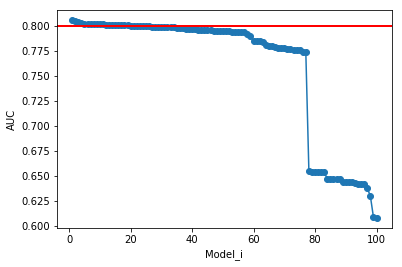

In [33]:
from matplotlib.pyplot import *

plot('rank_test_score', 'mean_test_score', data=df, marker='o')

xlabel("Model_i")
ylabel("AUC")

threshold = 0.8

matplotlib.pyplot.axhline(y=threshold, xmin=0, xmax=len(df), linewidth=2, color = 'red')

df[df["mean_test_score"]>threshold]